In [3]:
import torch
import matplotlib.pyplot as plt

from models.wta_cnp import WTA_CNP
from data.data_generators import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
# Hyperparameters
batch_size = 32
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 100
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 32
num_val_indiv = num_val//num_classes

colors = ['r', 'g', 'b', 'm']

X: torch.Size([100, 200, 1]) Y: torch.Size([100, 200, 1]) VX: torch.Size([32, 200, 1]) VY: torch.Size([32, 200, 1])


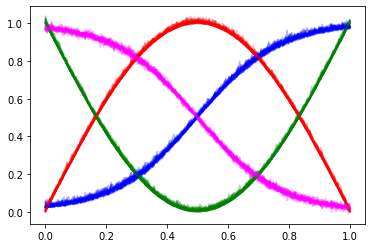

In [3]:
# Generating the data
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, generate_reverse_cx_sigm]

for i in range(num_classes):
    noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip
    y[i*num_indiv:(i+1)*num_indiv] = torch.unsqueeze(generator_functions[i](x) + noise, 2)
    noise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - noise_clip
    vy[i*num_val_indiv:(i+1)*num_val_indiv] = torch.unsqueeze(generator_functions[i](vx) + noise, 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

for i in range(num_indiv):
    plt.plot(x[i, :, 0], y[i, :, 0], 'r', alpha=0.3)
    plt.plot(x[i+num_indiv, :, 0], y[i+num_indiv, :, 0], 'g', alpha=0.3)
    plt.plot(x[i+2*num_indiv, :, 0], y[i+2*num_indiv, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+3*num_indiv, :, 0], y[i+3*num_indiv, :, 0], 'magenta', alpha=0.3)
plt.show()

x, y = x.to(device), y.to(device)

In [4]:
def get_batch(x, y, traj_ids):
    n_t = torch.randint(1, n_max_tar, (1,)).item()
    n_o = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    # print("Obs:", obs.shape, "Tar:", tar.shape, "Tar_val:", tar_val.shape)
    return obs, tar, tar_val

In [5]:
model = WTA_CNP(1, 1, 10, 10, [256, 256, 256], 4, [128, 128, 128], 32).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())
# model

In [6]:
import time

file_name = int(time.time())

epochs = 1000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
min_loss = 1000000
avg_loss = 0

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, gate = model(obs, tar_x)
        loss, _ = model.loss(pred, gate, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch_loss < min_loss and epoch > 5e4:
        min_loss = epoch_loss
        torch.save(model.state_dict(), f'saved_models/wtacnp_synth_{file_name}.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
        avg_loss = 0

    # if epoch % 5000 == 0:
    #     print(gate)

Epoch: 0, Loss: 0.08495762825012207
Epoch: 100, Loss: 3.4154069447517394
Epoch: 200, Loss: 2.7279336071014404
Epoch: 300, Loss: 2.6596158480644227
Epoch: 400, Loss: 2.4510766941308977
Epoch: 500, Loss: 2.220918290615082
Epoch: 600, Loss: 1.6644274542108177
Epoch: 700, Loss: 0.7702515851333738
Epoch: 800, Loss: -0.2134047119691968
Epoch: 900, Loss: -1.2112103183194995
Epoch: 1000, Loss: -2.202188923433423
Epoch: 1100, Loss: -3.3409621957689524
Epoch: 1200, Loss: -4.261239436790347
Epoch: 1300, Loss: -5.058625639602542
Epoch: 1400, Loss: -6.010960977748036
Epoch: 1500, Loss: -6.419982852861285
Epoch: 1600, Loss: -7.0724872789531945
Epoch: 1700, Loss: -7.46889635540545
Epoch: 1800, Loss: -8.0715499099344
Epoch: 1900, Loss: -8.748644533902407
Epoch: 2000, Loss: -8.879963125139476
Epoch: 2100, Loss: -9.55226415000856
Epoch: 2200, Loss: -9.431723546236753
Epoch: 2300, Loss: -9.83454652108252
Epoch: 2400, Loss: -9.927568507939577
Epoch: 2500, Loss: -10.537165340259671
Epoch: 2600, Loss: -11.2

In [5]:
def get_validation_batch(o_ids=[0, -1]):
    obs = torch.cat((vx[:, o_ids, :], vy[:, o_ids, :]), dim=-1)
    tar = vx[:, torch.arange(t_steps)]
    tar_val= vy[:, torch.arange(t_steps)]

    return obs, tar, tar_val

In [8]:
# Testing the best model
model = WTA_CNP(1, 1, 10, 10, [256, 256, 256], 4, [128, 128, 128], 32)
model.load_state_dict(torch.load(f'saved_models/wtacnp_synth_1678704864.pt'))
model.eval()

o, t, tr = get_validation_batch()

with torch.no_grad():
    p, g = model(o, t)

p, g = p.cpu().numpy(), g.cpu()
t, tr = t.cpu().numpy(), tr.cpu().numpy()

for i in range(batch_size):
    dec_id = torch.argmax(g[i, :, :]).item()
    plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.3)
    plt.plot(range(t_steps), tr[i, :, 0], 'k', alpha=0.3, linestyle='dashed')

RuntimeError: Error(s) in loading state_dict for WTA_CNP:
	Missing key(s) in state_dict: "encoder.4.weight", "encoder.4.bias", "decoders.0.2.weight", "decoders.0.2.bias", "decoders.1.2.weight", "decoders.1.2.bias", "decoders.2.2.weight", "decoders.2.2.bias", "decoders.3.2.weight", "decoders.3.2.bias". 
	Unexpected key(s) in state_dict: "decoders.0.1.weight", "decoders.0.1.bias", "decoders.1.1.weight", "decoders.1.1.bias", "decoders.2.1.weight", "decoders.2.1.bias", "decoders.3.1.weight", "decoders.3.1.bias". 

In [12]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

332556
332556
